# Fitting IP decay curves with SE

In [119]:
from SimPEG import DC
import numpy as np
from SimPEG import Mesh, Maps, Utils
from pymatsolver import PardisoSolver
from ipywidgets import *
%pylab inline
from matplotlib import colors
from simpegEMIP.SeogiUtils.View import Circle2D
import h5py
from pylab import cm
from matplotlib import gridspec
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Text', 'interactive', 'colors', 'Widget', 'Button']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
fname = 'output_simulation_sip.h5'
output_simulation = h5py.File(fname, 'r')
geology_names = np.array(["background", "overburden","porphyry", "stock", "halo", "clay", "mineralization"], dtype=str),    

In [4]:
fname = 'model_2d.h5'
model_2d = h5py.File(fname, 'r')

In [5]:
sigma = model_2d['sigma_2d'].value
eta = model_2d['eta_2d'].value
tau = model_2d['tau_2d'].value
c = model_2d['c_2d'].value

In [6]:
IO_3d = DC.IO()
survey_3d = IO_3d.from_ambn_locations_to_survey(
    survey_type='dipole-dipole',
    a_locations=output_simulation['a_locations'].value,
    b_locations=output_simulation['b_locations'].value,
    m_locations=output_simulation['m_locations'].value,
    n_locations=output_simulation['n_locations'].value,
    data_dc=output_simulation['dc_data'].value,
    data_dc_type='volt',
    data_sip=output_simulation['sip_data'].value,    
    data_sip_type='volt',
    line_inds = output_simulation['line_inds'].value,
    dimension=3
)

/Users/sgkang/Projects/simpeg/SimPEG/EM/Static/DC/IODC.py:229: UserWarning: code under construction - API might change in the future
  "code under construction - API might change in the future"


In [7]:
fig_dir = "/Users/sgkang/Dropbox/spectral_ip_paper/figures/"
# fig_dir = "/home/seogi/Dropbox/spectral_ip_paper/figures/"

In [8]:
line_inds = IO_3d.line_inds == 2

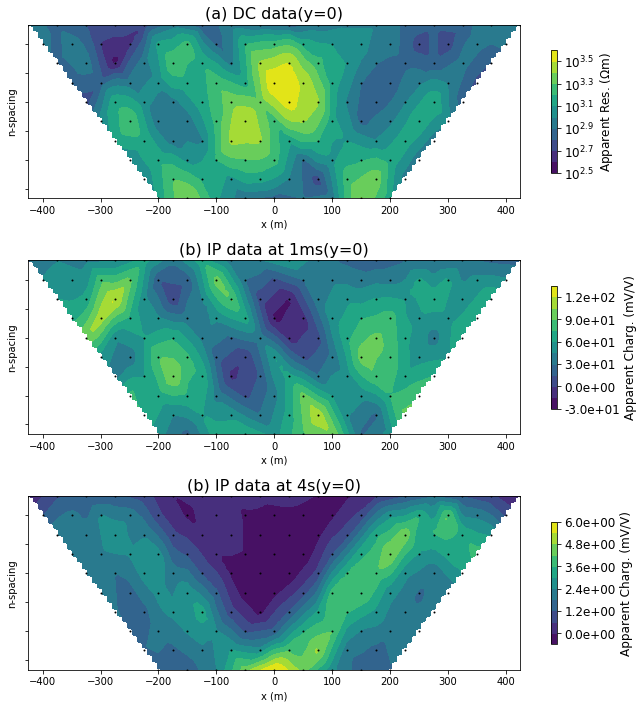

In [9]:
titles = ["(a) DC data", "(b) IP data at 1ms", "(b) IP data at 4s"]
fig = plt.figure(figsize = (10, 10))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)
IO_3d.plotPseudoSection(ax=ax1, data=IO_3d.data_dc/IO_3d.G, iline=2)
IO_3d.plotPseudoSection(
    data_type='apparent_chargeability', data=IO_3d.data_sip[:,0]/IO_3d.data_dc*1e3, scale='linear',
    ax=ax2, iline=2
)
IO_3d.plotPseudoSection(
    data_type='apparent_chargeability', data=IO_3d.data_sip[:,20]/IO_3d.data_dc*1e3, scale='linear',
    ax=ax3, iline=2
)
for i, ax in enumerate([ax1, ax2, ax3]):
    ax.set_title(titles[i] + "(y=0)", fontsize = 16)
plt.tight_layout()
fig.savefig(fig_dir+"data", dpi=200)

In [32]:
from SimPEG import (Maps, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)

def run_inversion(
    m0, survey, actind, mesh, wires,
    std, eps,
    maxIter=15, beta0_ratio=1e0,
    coolingFactor=2, coolingRate=2,
    maxIterLS=20, maxIterCG=10, LSshorten=0.5,
    eta_lower=1e-5, eta_upper=1,
    tau_lower=1e-6, tau_upper=10.,
    c_lower=1e-2, c_upper=1.,
    is_log_tau=True,
    is_log_c=True,
    is_log_eta=True,
    mref=None,
    alpha_s=1e-4,
    alpha_x=1e0,
    alpha_y=1e0,
    alpha_z=1e0,
):
    """
    Run Spectral Spectral IP inversion
    """
    dmisfit = DataMisfit.l2_DataMisfit(survey)
    uncert = abs(survey.dobs) * std + eps
    dmisfit.W = 1./uncert
    # Map for a regularization
    # Related to inversion

    # Set Upper and Lower bounds
    e = np.ones(actind.sum())

    if np.isscalar(eta_lower):
        eta_lower = e * eta_lower
    if np.isscalar(tau_lower):
        tau_lower = e * tau_lower
    if np.isscalar(c_lower):
        c_lower = e * c_lower

    if np.isscalar(eta_upper):
        eta_upper = e * eta_upper
    if np.isscalar(tau_upper):
        tau_upper = e * tau_upper
    if np.isscalar(c_upper):
        c_upper = e * c_upper

    if is_log_eta:
        eta_upper = np.log(eta_upper)
        eta_lower = np.log(eta_lower)

    if is_log_tau:
        tau_upper = np.log(tau_upper)
        tau_lower = np.log(tau_lower)

    if is_log_c:
        c_upper = np.log(c_upper)
        c_lower = np.log(c_lower)

    m_upper = np.r_[eta_upper, tau_upper, c_upper]
    m_lower = np.r_[eta_lower, tau_lower, c_lower]

    # Set up regularization
    reg_eta = Regularization.Sparse(
        mesh, mapping=wires.eta, indActive=actind
    )
    reg_tau = Regularization.Sparse(
        mesh, mapping=wires.tau, indActive=actind
    )
    reg_c = Regularization.Sparse(
        mesh, mapping=wires.c, indActive=actind
    )

    # Todo:

    reg_eta.alpha_s = alpha_s
    reg_tau.alpha_s = alpha_s
    reg_c.alpha_s = alpha_s

    reg_eta.alpha_x = alpha_x
    reg_tau.alpha_x = alpha_x
    reg_c.alpha_x = alpha_x

    reg_eta.alpha_y = alpha_y
    reg_tau.alpha_y = alpha_y
    reg_c.alpha_y = alpha_y

    reg_eta.alpha_z = alpha_z
    reg_tau.alpha_z = alpha_z
    reg_c.alpha_z = alpha_z

    reg = reg_eta + reg_tau + reg_c

    # Use Projected Gauss Newton scheme
    opt = Optimization.ProjectedGNCG(
        maxIter=maxIter, upper=m_upper, lower=m_lower,
        maxIterLS=maxIterLS, maxIterCG=maxIterCG, LSshorten=LSshorten
        )
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    beta = Directives.BetaSchedule(
        coolingFactor=coolingFactor, coolingRate=coolingRate
    )
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
    target = Directives.TargetMisfit()
    invProb.beta=0.
    directiveList = [
            target
    ]

    inv = Inversion.BaseInversion(
        invProb, directiveList=directiveList
        )
    opt.LSshorten = 0.5
    opt.remember('xc')

    # Run inversion
    mopt = inv.run(m0)
    print (target.target)
    return mopt, invProb.dpred


In [108]:
from SimPEG import SIP
from simpegEMIP.StretchedExponential import SEMultiInvProblem, SEMultiSurvey
mesh_1d = Mesh.TensorMesh([survey_3d.nD])
eta0 = np.ones(mesh_1d.nC)*0.01
tau0 = np.ones(mesh_1d.nC)*0.1
c0 = np.ones(mesh_1d.nC)*1.
actind_core = np.ones(mesh_1d.nC, dtype=bool)
eta_map, tau_map, c_map, wires =  SIP.spectral_ip_mappings(
    mesh_1d, indActive=actind_core, 
    is_log_eta=True,
    is_log_tau=True,
    is_log_c=True
)
# eta0 = abs(Utils.sdiag(1./IO_3d.data_dc)*IO_3d.data_sip[:,0])
m0 = np.r_[np.log(eta0), np.log(tau0), np.log(c0)]
dobs = (abs(Utils.sdiag(1./IO_3d.data_dc)*IO_3d.data_sip)).flatten()
def run_sip(m0):
    survey_curvefit = SEMultiSurvey(output_simulation['times'].value, np.zeros((survey_3d.nD,2)), n_pulse=2, T=16.)
    survey_curvefit.dobs = dobs
    prob_curvefit = SEMultiInvProblem(
        mesh_1d, etaMap = eta_map, tauMap = tau_map, cMap=c_map,
        Solver=PardisoSolver
    )
    prob_curvefit.pair(survey_curvefit)
    # m0 = np.r_[(eta0), np.log(tau0), (c0)]
    eps = 5e-4
    mopt, pred = run_inversion(
        m0, survey_curvefit, actind_core, mesh_1d, wires, 0.05, eps, 
        is_log_eta=True, 
        is_log_tau=True, 
        is_log_c=True,     
        maxIter=20, 
        tau_upper=1e2,
        alpha_s=0.1,
        coolingFactor=2.
    )
    return mopt, pred, survey_curvefit.dobs, prob_curvefit
mopt, pred, dobs, prob_curvefit = run_sip(m0)
eta_est_curvefit = np.exp(wires.eta * mopt)
tau_est_curvefit = np.exp(wires.tau * mopt)
c_est_curvefit = np.exp(wires.c * mopt)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  9.62e+05  0.00e+00  9.62e+05    2.24e+02      0              
   1  0.00e+00  3.38e+05  1.21e+02  3.38e+05    2.11e+02      2              
   2  0.00e+00  1.81e+05  3.34e+02  1.81e+05    3.97e+02      0              
   3  0.00e+00  2.08e+04  3.22e+02  2.08e+04    3.35e+02      0              
   4  0.00e+00  8.96e+03  3.52e+02  8.96e

In [109]:
times.shape

(21,)

In [110]:
times = output_simulation['times']
PRED = pred.reshape((mesh_1d.nC, times.size))
DOBS = dobs.reshape((mesh_1d.nC, times.size))

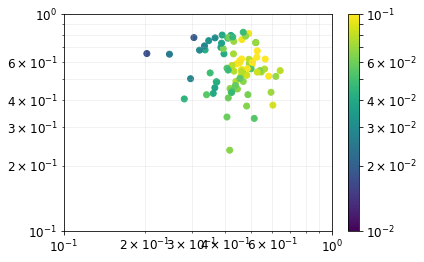

In [111]:
from matplotlib import colors
fig = plt.figure()
inds = ((abs(PRED-DOBS) / (0.05*abs(DOBS)+4e-4))**2).sum(axis=1) < 21
inds  = inds & (IO_3d.line_inds == 2)
out = plt.scatter(
    tau_est_curvefit[inds], c_est_curvefit[inds], c=eta_est_curvefit[inds],
    norm=colors.LogNorm(), vmin=0.01, vmax=0.1
)
plt.colorbar(out)
plt.xlim(1e-1, 1.)
plt.ylim(0.1, 1.)
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both", alpha=0.2)

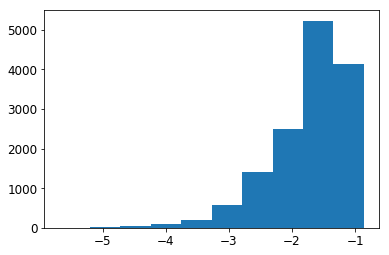

In [112]:
out = hist(np.log10(dobs))

In [113]:
slow_inds = (inds) & (c_est_curvefit<0.65) 
fast_inds = (inds) & (c_est_curvefit>0.65) 

In [114]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

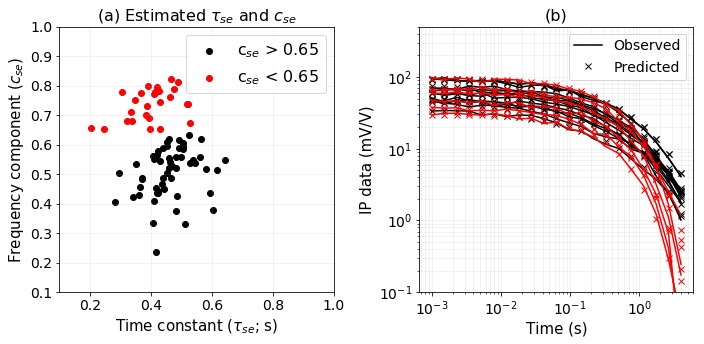

In [115]:
from matplotlib import colors
fig, axs = plt.subplots(1, 2, figsize=(10,5))
out = axs[0].scatter(
    tau_est_curvefit[slow_inds], c_est_curvefit[slow_inds], c='black',
    norm=colors.LogNorm(), vmin=0.01, vmax=0.1
)

out = axs[0].scatter(
    tau_est_curvefit[fast_inds], c_est_curvefit[fast_inds], c='red',
    norm=colors.LogNorm(), vmin=0.01, vmax=0.1
)
# plt.colorbar(out)
axs[0].set_xlim(1e-1, 1.)
axs[0].set_ylim(0.1, 1.)
axs[0].set_xscale("linear")
axs[0].set_yscale("linear")
axs[0].grid(which="both", alpha=0.2)

temp_dobs = DOBS[slow_inds,:] * 1e3
temp_pred = PRED[slow_inds,:] * 1e3
out = axs[1].loglog(times, temp_dobs.T[:,0], 'k-')
out = axs[1].loglog(times, temp_pred.T[:,0], 'kx')
axs[1].legend(("Observed", "Predicted"), fontsize = 14)
out = axs[1].loglog(times, temp_dobs.T[:,::5], 'k-')
out = axs[1].loglog(times, temp_pred.T[:,::5], 'kx')
temp_dobs = DOBS[fast_inds,:] * 1e3
temp_pred = PRED[fast_inds,:] * 1e3
out = axs[1].loglog(times, temp_dobs.T[:,::5], 'r-')
out = axs[1].loglog(times, temp_pred.T[:,::5], 'rx')
axs[1].set_ylim(1e-1, 500)
axs[0].set_xlabel("Time constant ($\\tau_{se}$; s)", fontsize = 15)
axs[0].set_ylabel("Frequency component ($c_{se}$)", fontsize = 15)
axs[1].set_xlabel("Time (s)", fontsize = 15)
axs[1].set_ylabel("IP data (mV/V)", fontsize = 15)
axs[1].grid(which="both", alpha=0.2)
axs[0].legend(("c$_{se}$ > 0.65", "c$_{se}$ < 0.65"), fontsize = 16)
axs[0].set_title("(a) Estimated $\\tau_{se}$ and $c_{se}$", fontsize = 16)
axs[1].set_title("(b)", fontsize = 16)
plt.tight_layout()
fig.savefig(fig_dir+"data_analyses", dpi=200)

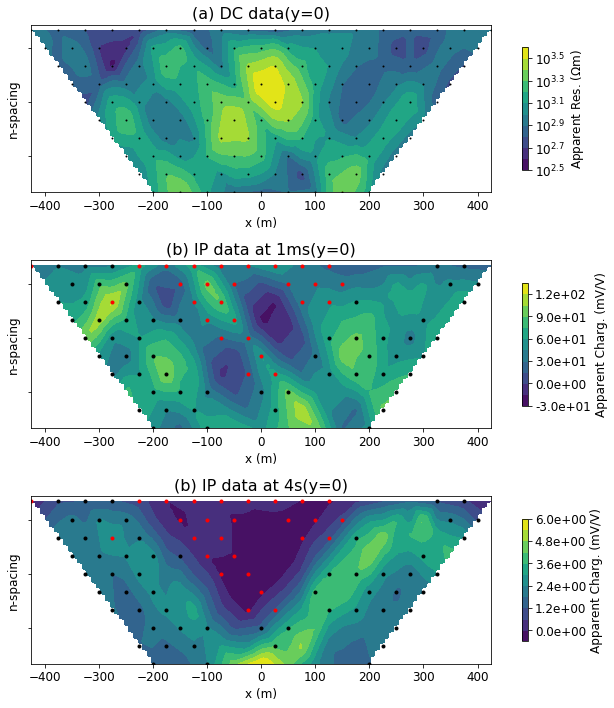

In [117]:
titles = ["(a) DC data", "(b) IP data at 1ms", "(b) IP data at 4s"]
fig = plt.figure(figsize = (10, 10))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)
IO_3d.plotPseudoSection(ax=ax1, data=IO_3d.data_dc/IO_3d.G, iline=2)
IO_3d.plotPseudoSection(
    data_type='apparent_chargeability', data=IO_3d.data_sip[:,0]/IO_3d.data_dc*1e3, scale='linear',
    ax=ax2, iline=2, dataloc=False,
)
IO_3d.plotPseudoSection(
    data_type='apparent_chargeability', data=IO_3d.data_sip[:,20]/IO_3d.data_dc*1e3, scale='linear',
    ax=ax3, iline=2, dataloc=False,
)
for i, ax in enumerate([ax1, ax2, ax3]):
    ax.set_title(titles[i] + "(y=0)", fontsize = 16)
    if i>0:
        ax.plot(IO_3d.grids[slow_inds,0], IO_3d.grids[slow_inds,2], 'ko', ms=3)
        ax.plot(IO_3d.grids[fast_inds,0], IO_3d.grids[fast_inds,2], 'ro', ms=3)
    ax.set_ylim(IO_3d.grids[:,2].max(), IO_3d.grids[:,2].min()-5)
plt.tight_layout()
fig.savefig(fig_dir+"data", dpi=200)